In [1]:
import numpy as np
import random
import torch
import importlib
import os

import sys
sys.path.append('../')

from models.network import AutoEncoder, ImageAutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## folder for testing
is_svr = True
epoch = 1000
use_phase = False
phase = 2

testing_folder = r'./../pretrain/class_run_1/' + ('image_encoder/' if is_svr else 'phase_2_model')
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

## dataload
### create dataset
data_path = r'./../data/all_vox256_img_with_classes/all_vox256_img_test.hdf5'

testing_flag = True
if os.path.exists(config.data_path) and not testing_flag:
    data_path = config.data_path

model_type = f"AutoEncoder-{config.encoder_type}-{config.decoder_type}" if config.network_type == 'AutoEncoder' else f"AutoDecoder-{config.decoder_type}"

samples = ImNetImageSamples(data_path=data_path, sample_class=True)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) 
        for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]
network_path

'./../pretrain/class_run_1/image_encoder/model_epoch_1000.pth'

((1, 128, 128), <matplotlib.image.AxesImage at 0x7faebd3e2fd0>)

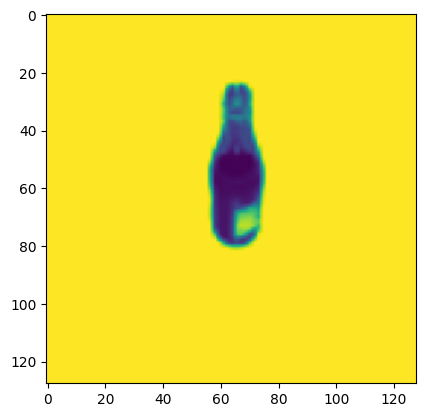

In [108]:
import cv2

def zoom_at(img, zoom=1, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return result


target_wh = 128, 128

img = np.ones((1, target_wh[1], target_wh[0]), dtype=np.uint8) * 255

img_loaded = cv2.imread('bottle_big.png') # masked-chair_1.png cup-masked.png
if img_loaded.shape[0] > img_loaded.shape[1]:
    res_wh = (
        int(img_loaded.shape[1] / (img_loaded.shape[0] // target_wh[0])), 
        target_wh[1]
    )
else:
    res_wh = (
        target_wh[0],
        int(img_loaded.shape[0] / (img_loaded.shape[1] // target_wh[1])), 
    )
    
additional_shift_wh = (
    (target_wh[0] - res_wh[0])//2,
    (target_wh[1] - res_wh[1])//2
)

img_loaded = cv2.resize(img_loaded, res_wh, interpolation=cv2.INTER_AREA)
# img_loaded = zoom_at(img_loaded, 1.5)
img_loaded = img_loaded[..., 0]
img[:, additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = img_loaded
img = img.astype(np.float32)
img /= 255
img.shape, plt.imshow(img[0])

(<matplotlib.image.AxesImage at 0x7faebddf5a00>,
 64,
 20000,
 (-0.5, 0.5),
 0.01,
 '04090263/ce38b5d04d546346f27eb335b754fdaa',
 True)

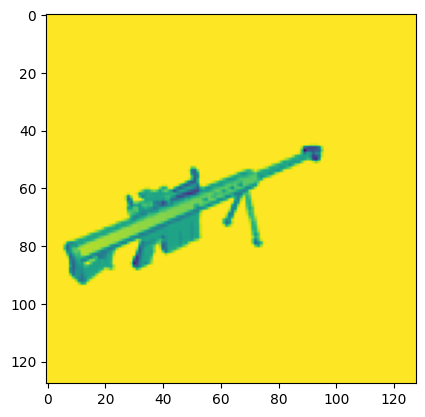

In [44]:
indx = 0
obj_indx = 12

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]
gt_voxel, gt_points, gt_values, gt_class = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample],
    samples.data_classes[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

plt.imshow(np.squeeze(img)), resolution, max_batch, space_range, thresh, obj_path, sur_point

In [5]:
if is_svr:
    network = ImageAutoEncoder(config=config).to(device)
    config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
    assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
    auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
    auto_config = importlib.util.module_from_spec(auto_spec)
    auto_spec.loader.exec_module(auto_config)

    auto_encoder = AutoEncoder(config=auto_config).to(device)
    network.set_autoencoder(auto_encoder)
else:
    network = AutoEncoder(config=config).to(device)

In [81]:
network_state_dict = torch.load(network_path)
for key, item in list(network_state_dict.items()):
    if key[:7] == 'module.':
        network_state_dict[key[7:]] = item
        del network_state_dict[key]
network.load_state_dict(network_state_dict)
_ = network.eval()

In [109]:
if is_svr:
    input_torch = torch.from_numpy(img).float().to(device)
else:
    input_torch = torch.from_numpy(gt_voxel).float().to(device)
input_torch.shape

torch.Size([1, 128, 128])

In [110]:
if is_svr:
    embedding = network.image_encoder(input_torch.unsqueeze(0))
else:
    embedding = network.encoder(input_torch.unsqueeze(0))
embedding.shape

torch.Size([1, 384])

In [111]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list, pd_class,
 convex_predictions_sum, point_value_prediction) = network.auto_encoder.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

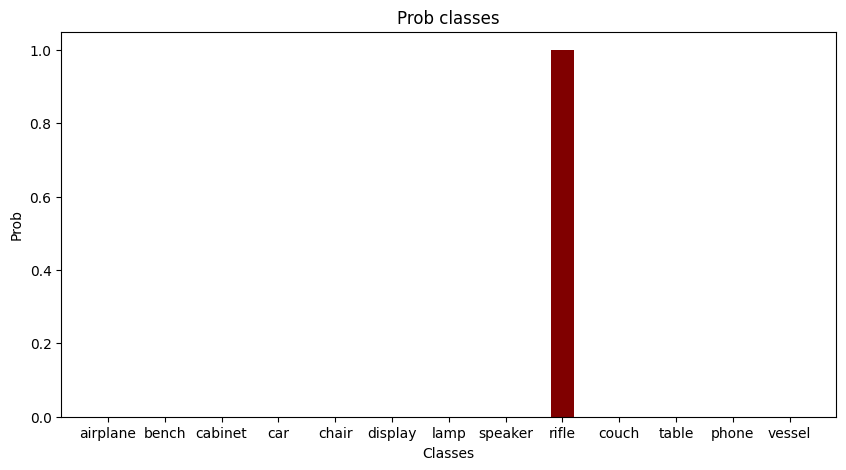

In [112]:
from evaluation.eval_utils import class_id_and_name_list
from scipy.special import softmax

class_probs = softmax(pd_class)
indx_class = np.argmax(pd_class)
class_id_and_name_list[indx_class]

# creating the dataset
data = dict(zip(
    map(lambda x: x.split('_')[-1], class_id_and_name_list), 
    class_probs
))
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("Prob")
plt.title("Prob classes")
plt.show()

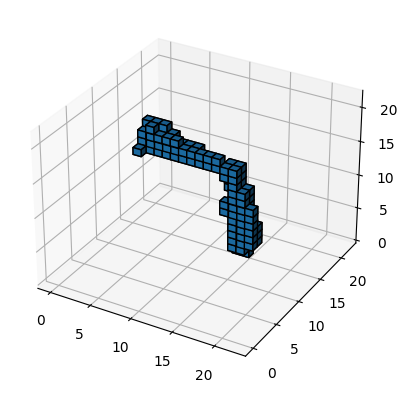

In [113]:
voxelarray = (convex_predictions_sum > 0).astype(np.int32)

ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(voxelarray[::3, ::3, ::3], edgecolor='k')

In [95]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)